# computing boundary matrix from blowup chain complex
First define the blowup chain complex from a simplicial cover.
Then we compute the boundaries of each simplex in the blowup chain complex  



## Data structure
The blowup chain complex is a direct product of simplicial complex $X^J$ and $\Delta^J$
Each simplex is a pair $(\sigma,\delta)$ where $\sigma\in X^J$ and $\delta\in\Delta^J$

In [167]:
class ProductSimplex:
    def __init__(self, sigma,delta,id=0):
        self.sigma =  sigma  
        self.delta  =  delta  
        self.id = id
        self.dim_s = max(len(self.sigma)-1,0) 
        self.dim_d = max(len(self.delta)-1,0)
        self.dim = self.dim_s +  self.dim_d 
        self.boundary=[] 
        
    def print(self):
        print( "id=",self.id,"simplex=",(self.sigma,self.delta), "dim=",self.dim)
        if self.boundary:
            print("boundary:",self.boundary)
            
    def to_ordered_simplex(self):
        simplex = self.sigma if len(self.sigma)==self.dim+1 else self.sigma + [0]*(self.dim+1-len(self.sigma)) # append zeros
        return (simplex, self.dim_d)

In [168]:
ProductSimplex([0,1],[0,1]).print()
# test dimension padding
print(ProductSimplex([0,1],[0]).to_ordered_simplex())
print(ProductSimplex([0],[0,1]).to_ordered_simplex())
print(ProductSimplex([0,1],[0,1]).to_ordered_simplex())
print(ProductSimplex([1],[0,1,2]).to_ordered_simplex())


id= 0 simplex= ([0, 1], [0, 1]) dim= 2
([0, 1], 0)
([0, 0], 1)
([0, 1, 0], 1)
([1, 0, 0], 2)


## Helper functions

In [169]:

def make_standard_simplex(n):
    # standard simplex Delta^J 
    # Delta^J  = [ ([0],0), ([1],0),([0,1],1) ]
    D_J = [] 
    for i in range(n):
        c = list(itertools.combinations(range(n),i+1)) 
        D_J = D_J + [   list(s)   for s in c]  
    return D_J


In [170]:
def simplicial_product(complex, delta,i_start):
    # e.g. complex = [[1], [2], [1, 2]]   # detla=[0,1]
    # resulting productsimplex are 
    # ProductSimplex([1],[0,1]), ProductSimplex([2],[0,1]),ProductSimplex([1,2],[0,1]) 

    return [ProductSimplex(sigma,delta,i+i_start) for i, sigma in enumerate(complex)] 

In [171]:
def subset_intersection(list_of_complexes): 
    # compute intersection of a list of simplicial covers
    sets = []
    for CP in list_of_complexes: 
        sets.append(  set([tuple(sigma) for sigma in CP]))
    intersection = set.intersection(*sets) 
    # sort by simplex dimension, then by simplex id
    intersection  = sorted(intersection, key=lambda x: (len(x ) , x[0] )) 
    
    return [list(t) for t in intersection]


# BlowupComplex

Expernal Function:
- BlowupComplex(simplicial_cover): build blowup complex
- compute_persistence(): compute and visualize the persistence barcode
- print_complex(): print out information of the blowup complex
  
Internal Functions:
- construct_from_cover(): construct blowup complex $X^U$ as a direct product 
- compute_boundary_delta(D_J): compute boundary of $\Delta^J$
- compute_boundary(D_J,B_delta): compute boundary of blowup complex $X^U$


In [232]:
class BlowupComplex():
    def __init__(self, simplicial_cover):
        self.U = simplicial_cover  
        self.X_U = []   # list of lists of ProductSimplex (to do : make it iterable)
        self._construct_from_cover()
        
    def print_complex(self):
        # display the constructed blowup complex X_U
        for X_U_t in self.X_U: 
            for sp in X_U_t:
                sp.print()

    
    def _construct_from_cover(self): 
        i_start=0
        D_J  = make_standard_simplex(len(self.U)) 
        for delta in D_J:
            
            X_J = subset_intersection([ self.U[d] for d in delta])  
            X_U_t = simplicial_product(X_J,delta,i_start)
            i_start += len(X_U_t)
            self.X_U.append( X_U_t  )
        
        # map simplex tuples to global id
        flattened_list =[ ( tuple(sp.sigma),tuple(sp.delta) )  for i in range(len(D_J)) for sp in self.X_U[i]]
        self.sp_to_id  = dict( [(sp,i) for i,sp in enumerate(flattened_list)])

        B_delta  = self._compute_boundary_delta(D_J) 
        print(B_delta)
        self._compute_boundary(D_J,B_delta)
        

    def _compute_boundary_delta(self,D_J):
        ordered_simplex_delta =  [  ( delta, len(delta)-1) for delta in D_J]  
        B_delta = cm.solver._simplices_to_sparse_pivot_column(ordered_simplex_delta ,False)
        return B_delta

    
    def _compute_boundary(self,D_J,B_delta ):
        for t,delta in enumerate(D_J): 
            
            # construct a filtration on Xi
            # fill in block diagonal boundary matrix by using builtin boundary operator
            ordered_simplex = [  ( sp.sigma, sp.dim_d) for sp in self.X_U[t] ]
            B = cm.solver._simplices_to_sparse_pivot_column(ordered_simplex ,False)
            
            for i,sp in enumerate(self.X_U[t]): 
                sp.boundary = [self.X_U[t][j].id for j in B[i][1]] 
            
            # fill in the upper triangular area for deltas with non-empty boundary
            if len(delta)>1: 
                for sp in self.X_U[t]: 
                    dim,boundary_delta  = B_delta[t] 
                    
                    #[2,3]x [0,1] -> [2,3]x[0], [2,3]x[1]
                    for tt in boundary_delta: 
                        boundary_delta_simplex = D_J[tt] 
                        sp.boundary.append(  self.sp_to_id[  (tuple(sp.sigma), tuple(  boundary_delta_simplex   ))]) 
                    
            for sp in self.X_U[t]:
                sp.boundary = sorted(sp.boundary,key=lambda x: (  x  ))
                
    
    def compute_persistence(self,verbose=False):
        # convert simplices and boundary to the column format for persistence
        ordered_simplices = [sp.to_ordered_simplex()   for X_U_T in self.X_U  for sp in  X_U_T   ]  
        if verbose:
            print('simplices',ordered_simplices)
        
        columns = [ (sp.dim, sp.boundary )    for X_U_T in self.X_U for sp in  X_U_T]  

        if verbose:
            print('boundary columns')
            for col in columns:
                print(col)
        # for coloring localized cycles
        cover = [ ''.join([str(s) for s in sp.delta ])  for X_U_T in self.X_U  for sp in  X_U_T   ]  
        if verbose:
            print('cover',cover)
        self.dgms = compute_blowup(ordered_simplices, columns,cover, show_diag=True) 

## Construct blowup simplex

[(0, []), (0, []), (1, [0, 1])]
simplices [([0], 0), ([1], 0), ([2], 0), ([0, 1], 0), ([1, 2], 0), ([1], 0), ([2], 0), ([3], 0), ([1, 2], 0), ([2, 3], 0), ([1, 0], 1), ([2, 0], 1), ([1, 2, 0], 1)]
boundary columns
(0, [])
(0, [])
(0, [])
(1, [0, 1])
(1, [1, 2])
(0, [])
(0, [])
(0, [])
(1, [5, 6])
(1, [6, 7])
(1, [1, 5])
(1, [2, 6])
(2, [4, 8, 10, 11])
cover ['0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '01', '01', '01']
display h classes on diagonal
(1, 3)
(2, 4)
(5, 10)
(6, 8)
(7, 9)
(11, 12)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1']], 1: [[1, 1, '01']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, inf, '0']]
[[2, (0, 0)], [2, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [2, (0, inf)]]


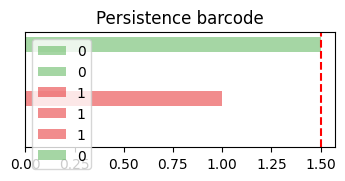

H1 [[1, 1, '01']]
[[1, (1, 1)]]


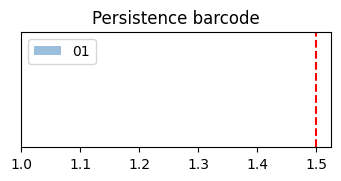

In [234]:
# first construct the product simplicial complex

X0 = [[0], [1],[2],[0,1],[1,2]]
X1 = [[1],[2], [3], [1,2],[2,3]]   

blowup = BlowupComplex([X0,X1])

#blowup.print_complex()
blowup.compute_persistence(verbose=True)


D_J [[0], [1], [0, 1]]
simplex to id map: {((0,), (0,)): 0, ((1,), (0,)): 1, ((2,), (0,)): 2, ((3,), (0,)): 3, ((0, 1), (0,)): 4, ((0, 2), (0,)): 5, ((1, 3), (0,)): 6, ((1, 2), (0,)): 7, ((2, 3), (0,)): 8, ((1,), (1,)): 9, ((2,), (1,)): 10, ((3,), (1,)): 11, ((4,), (1,)): 12, ((1, 3), (1,)): 13, ((1, 2), (1,)): 14, ((2, 4), (1,)): 15, ((2, 3), (1,)): 16, ((3, 4), (1,)): 17, ((1,), (0, 1)): 18, ((2,), (0, 1)): 19, ((3,), (0, 1)): 20, ((1, 2), (0, 1)): 21, ((1, 3), (0, 1)): 22, ((2, 3), (0, 1)): 23}
[(0, []), (0, []), (1, [0, 1])]
------t= 0 delta= [0] ----------
id= 0 simplex= ([0], [0]) dim= 0
id= 1 simplex= ([1], [0]) dim= 0
id= 2 simplex= ([2], [0]) dim= 0
id= 3 simplex= ([3], [0]) dim= 0
id= 4 simplex= ([0, 1], [0]) dim= 1
boundary: [0, 1]
id= 5 simplex= ([0, 2], [0]) dim= 1
boundary: [0, 2]
id= 6 simplex= ([1, 3], [0]) dim= 1
boundary: [1, 3]
id= 7 simplex= ([1, 2], [0]) dim= 1
boundary: [1, 2]
id= 8 simplex= ([2, 3], [0]) dim= 1
boundary: [2, 3]
------t= 1 delta= [1] ----------
id

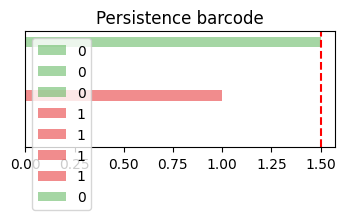

H1 [[0, 1, '1'], [1, 1, '01'], [1, 1, '01'], [0, inf, '0'], [0, inf, '0'], [0, inf, '1']]
[[0, (0, 1)], [1, (1, 1)], [1, (1, 1)], [2, (0, inf)], [2, (0, inf)], [0, (0, inf)]]


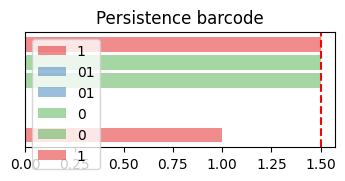

In [229]:



X0 =  [[0], [1], [2], [3], [0,1],[0,2],[1,2],[1,3], [2,3]]
X1 =  [[1], [2], [3],[4],[1,2],[1,3],[2,3],[2,4],[3,4]]

blowup = BlowupComplex([X0,X1])
blowup.compute_persistence()



[(0, []), (0, []), (0, []), (1, [0, 1]), (1, [0, 2]), (1, [1, 2]), (2, [3, 4, 5])]
display h classes on diagonal
(1, 3)
(2, 4)
(5, 6)
{0: [[0, 1, '1'], [0, 1, '2']], 1: [[1, 2, '12']]}
H0 [[0, 1, '1'], [0, 1, '2'], [0, inf, '0']]
[[5, (0, 1)], [0, (0, 1)], [4, (0, inf)]]


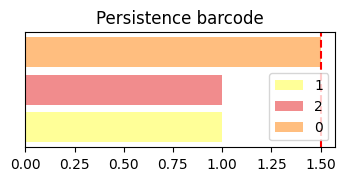

H1 [[1, 2, '12']]
[[2, (1, 2)]]


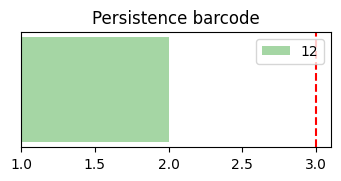

In [235]:
X0 =  [ [0] ]
X1 = [[0] ]
X2 = [[0] ]
                     

blowup = BlowupComplex([X0,X1,X2])
blowup.compute_persistence()


[(0, []), (0, []), (0, []), (1, [0, 1]), (1, [0, 2]), (1, [1, 2]), (2, [3, 4, 5])]
display h classes on diagonal
(1, 4)
(2, 5)
(3, 6)
(7, 21)
(8, 11)
(9, 12)
(10, 13)
(14, 24)
(15, 18)
(16, 20)
(17, 19)
(22, 23)
(25, 26)
(28, 29)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2'], [0, 0, '2'], [0, 0, '2']], 1: [[1, 1, '01'], [1, 1, '02'], [1, 1, '12']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2'], [0, 0, '2'], [0, 0, '2'], [0, inf, '0']]
[[3, (0, 0)], [3, (0, 0)], [3, (0, 0)], [4, (0, 1)], [4, (0, 0)], [4, (0, 0)], [4, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [0, (0, 0)], [3, (0, inf)]]


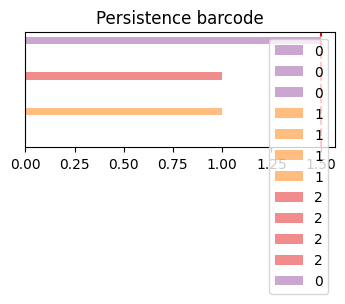

H1 [[1, 1, '01'], [1, 1, '02'], [1, 1, '12'], [1, inf, '12']]
[[1, (1, 1)], [5, (1, 1)], [2, (1, 1)], [2, (1, inf)]]


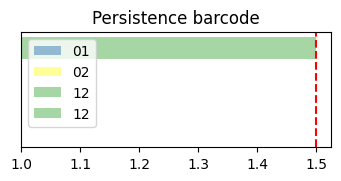

In [236]:
 
X0= [[0],[1],[2],[3],[0,1],[1,2],[2,3]]  
X1=[[2],[3],[4],[5] ,[2,3],[3,4],[4,5]]   
X2= [[0],[1],[4],[5],[0,1],[0,5],[4,5]]

blowup = BlowupComplex([X0,X1,X2])
blowup.compute_persistence()